# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig


@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = '/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [4]:
torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [7]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [8]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [9]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

## Clip Labeling AutoInterp

In [10]:
# all_imagenet_class_names

In [11]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [12]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/layer_9'

## Feature steering

In [13]:
def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    print(steered_sae_out.shape)
    print(steered_sae_out.shape)
    print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [14]:
random_feat_idxs = np.random.randint(0, high=3000, size=(25))

In [15]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10,
    steering_strength: float = 10.0
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
#     _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
        print(f"Feature: {idx} ====================")
        
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=steering_strength,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
            fwd_hooks=[("blocks.9.hook_mlp_out", steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[("blocks.9.hook_mlp_out", lambda x, hook: x)],
    )
    
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default}")
    print(f"recons_image_embeddings_default.shape: {recons_image_embeddings_default.shape}")
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default.shape}")

    print(f"recons_image_embeddings_feat_altered: {recons_image_embeddings_feat_altered}")
    print(f"recons_image_embeddings_feat_altered.shape: {recons_image_embeddings_feat_altered.shape}")

    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

In [109]:
from collections import defaultdict
max_samples = cfg.eval_max

# top_activations = {i: (None, None) for i in interesting_features_indices}
encoder_biases = sparse_autoencoder.b_enc#[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc#[:, interesting_features_indices]

# positive = -1 * np.array([-50.0, -20.0, -10.0, -5.0, -2.5, -1.5, -1.0, -.75, -.5, -.25, -.1])
# steering_strengths = np.array([-50.0, -20.0, -10.0, -5.0, -2.5, -1.5, -1.0, -.75, -.5, -.25, -.1, 0])
# steering_strengths = np.concatenate((steering_strengths, positive))
# print(steering_strengths)
# strengths = defaultdict(list)
# for steering_strength in steering_strengths:
steering_strength = 150

top_k=10
processed_samples = 0
default_embeds_list = []
feature_steered_embeds = defaultdict(list)
l = 0
for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
    batch_images = batch_images.to(cfg.device)
    batch_indices = batch_indices.to(cfg.device)
    batch_size = batch_images.shape[0]

    altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
        batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
        None, None, top_k, steering_strength
    )
    default_embeds_list.append(default_embeds)
    for j, altered_embeds in enumerate(altered_embeds_list):
        feature_steered_embeds[random_feat_idxs[j]].extend(altered_embeds)
    # either label embeds or optimize to maximal token in text transformer embedding face
    l += 1
    if l >= 5:
        break    
        

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 166 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
Feature: 2690 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.00048828125
error.norm(): 561.3306884765625
Feature: 2031 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 5999.8203125
error.norm(): 561.3306884765625
Feature: 1413 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 5999.99951171875
error.norm(): 561.3306884765625
Feature: 835 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
Feature: 2541 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
Feature: 2605 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.00048828125
error.norm(

  0%|                                                                                                            | 0/1562 [00:01<?, ?it/s]


In [95]:
len(feature_steered_embeds[random_feat_idxs[0]])

160

In [96]:
default_embeds.shape
len(default_embeds_list)
default_embeds = torch.cat(default_embeds_list)
default_embeds.shape

torch.Size([160, 512])

In [97]:

len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

(25, torch.Size([32, 512]), torch.Size([160, 512]))

In [98]:
og_model.cuda()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [99]:
with open("/workspace/clip_dissect_raw.txt", "r") as f:
    larger_vocab = [line[:-1] for line in f.readlines()][:5000]

# with open("/workspace/better_img_desc.txt", "r") as f:
#     larger_vocab = [line[:-1] for line in f.readlines()][:5000]

In [100]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(larger_vocab)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


print(f"text_features_normed.shape: {text_features_normed.shape}")
text_probs_altered_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for key in feature_steered_embeds:
        print(key)
        # embeds already have L2 norm of 1
        text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

text_features_normed.shape: torch.Size([5000, 512])
166
2690
2031
1413
835
2541
2605
2833
388
138
2436
1804
1191
2741
2545
452
2183
905
2125
2693
2298
1548
2395
1175
1356
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])


### Summed Logit Difference

In [101]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

top_concept_per_feat = {}
top_val_per_feat = {}
top_diff_per_feat = {}
top_ratio_per_feat = {}
# run this for sampled features over all of imagenet eval
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
    print("actual image content:")
    default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
    print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])
    
    
    logit_diff = text_probs_altered - text_probs_default
    logit_diff_aggregate = logit_diff.sum(dim=0)
    
    logit_ratio = text_probs_altered/text_probs_default
    logit_ratio_aggregate = logit_ratio.mean(dim=0)
    
    print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
    text_probs_altered_softmax = text_probs_altered.softmax(1)
    vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)
    
#     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
#     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
#     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)
    
    print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
    print(np.array(selected_vocab)[idxs_softmax.cpu()])
    for i in range(vals_softmax.shape[0]):
        print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
        break
        
#     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
#     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])
    
    vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
    vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)
    
    ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
    ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
    top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
    top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
    top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]
    
    
    print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
    print(np.array(selected_vocab)[idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[idxs_least_agg.cpu()])
    
    print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
    print(ratios_agg)
    print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])


For Feature 166
actual image content:
tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002

tensor([[0.5584, 0.1575, 0.0111,  ..., 0.0055, 0.0047, 0.0047],
        [0.7183, 0.0722, 0.0352,  ..., 0.0058, 0.0052, 0.0032],
        [0.1819, 0.1020, 0.0770,  ..., 0.0177, 0.0175, 0.0159],
        ...,
        [0.8843, 0.0097, 0.0054,  ..., 0.0026, 0.0025, 0.0024],
        [0.1088, 0.0630, 0.0610,  ..., 0.0279, 0.0228, 0.0208],
        [0.5017, 0.0581, 0.0283,  ..., 0.0116, 0.0101, 0.0098]],
       device='cuda:0') 
 [['python' 'debian' 's' ... 'rubber' 'male' 'rolling']
 ['ski' 'sequence' 'trembl' ... 'turns' 'board' 'pair']
 ['dog' 'golden' 'adopted' ... 'pussy' 'douglas' 'charles']
 ...
 ['gun' 'thompson' 'model' ... 'shown' 'lower' 'shooting']
 ['tables' 'boards' 'table' ... 'hall' 'sit' 'before']
 ['gardens' 'square' 'park' ... 'lens' 'campus' 'photo']]
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0

In [102]:
top_concept_per_feat,top_val_per_feat,top_ratio_per_feat

({166: 'mike',
  2690: 'foto',
  2031: 'font',
  1413: 'header',
  835: 'thumbnail',
  2541: 'dragon',
  2605: 'trailers',
  2833: 'who',
  388: 'formula',
  138: 'back',
  2436: 'dragon',
  1804: 'preview',
  1191: 'comparison',
  2741: 'holder',
  2545: 'header',
  452: 'front',
  2183: 'bb',
  905: 'phone',
  2125: 'button',
  2693: 'restaurants',
  2298: 'highly',
  1548: 'layout',
  2395: 'certificates',
  1175: 'postal',
  1356: 'lot'},
 {166: tensor(0.0002, device='cuda:0'),
  2690: tensor(0.0002, device='cuda:0'),
  2031: tensor(0.0002, device='cuda:0'),
  1413: tensor(0.0002, device='cuda:0'),
  835: tensor(0.0002, device='cuda:0'),
  2541: tensor(0.0005, device='cuda:0'),
  2605: tensor(0.0002, device='cuda:0'),
  2833: tensor(0.0002, device='cuda:0'),
  388: tensor(0.0002, device='cuda:0'),
  138: tensor(0.0004, device='cuda:0'),
  2436: tensor(0.0002, device='cuda:0'),
  1804: tensor(0.0002, device='cuda:0'),
  1191: tensor(0.0002, device='cuda:0'),
  2741: tensor(0.0002, d

In [103]:
# steering_strength_info = {}
steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


In [104]:
steering_strength_info[steering_strength][0].keys()

dict_keys([166, 2690, 2031, 1413, 835, 2541, 2605, 2833, 388, 138, 2436, 1804, 1191, 2741, 2545, 452, 2183, 905, 2125, 2693, 2298, 1548, 2395, 1175, 1356])

In [105]:
steering_strength_info

{0.0: ({166: 'python',
   2690: 'python',
   2031: 'python',
   1413: 'python',
   835: 'python',
   2541: 'python',
   2605: 'python',
   2833: 'python',
   388: 'python',
   138: 'python',
   2436: 'python',
   1804: 'python',
   1191: 'python',
   2741: 'python',
   2545: 'python',
   452: 'python',
   2183: 'python',
   905: 'python',
   2125: 'python',
   2693: 'python',
   2298: 'python',
   1548: 'python',
   2395: 'python',
   1175: 'python',
   1356: 'python'},
  {166: tensor(0.0003, device='cuda:0'),
   2690: tensor(0.0003, device='cuda:0'),
   2031: tensor(0.0003, device='cuda:0'),
   1413: tensor(0.0003, device='cuda:0'),
   835: tensor(0.0003, device='cuda:0'),
   2541: tensor(0.0003, device='cuda:0'),
   2605: tensor(0.0003, device='cuda:0'),
   2833: tensor(0.0003, device='cuda:0'),
   388: tensor(0.0003, device='cuda:0'),
   138: tensor(0.0003, device='cuda:0'),
   2436: tensor(0.0003, device='cuda:0'),
   1804: tensor(0.0003, device='cuda:0'),
   1191: tensor(0.0003, d

In [106]:
i = 0
for feat_num in steering_strength_info[steering_strength][0].keys():
    print(f"=====================\nfeat_num: {feat_num}")
    feat_num_concept_arr = []
    feat_num_prob_arr = []
    feat_num_ratio_arr = []
    for key in steering_strength_info:
        print(key, steering_strength_info[key][0][feat_num])
        feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
        print(key, steering_strength_info[key][1][feat_num])
        feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
        print(key, steering_strength_info[key][2][feat_num])
        feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
    i += 1
    if i > 5:
        break

feat_num: 166
0.0 python
0.0 tensor(0.0003, device='cuda:0')
0.0 tensor(1.0004, device='cuda:0')
1.0 python
1.0 tensor(0.0003, device='cuda:0')
1.0 tensor(1.4109, device='cuda:0')
2.5 python
2.5 tensor(0.0003, device='cuda:0')
2.5 tensor(2.4751, device='cuda:0')
7.5 python
7.5 tensor(0.0003, device='cuda:0')
7.5 tensor(27.1139, device='cuda:0')
75 mike
75 tensor(0.0002, device='cuda:0')
75 tensor(628112.0625, device='cuda:0')
150 mike
150 tensor(0.0002, device='cuda:0')
150 tensor(3236189.2500, device='cuda:0')
feat_num: 2690
0.0 python
0.0 tensor(0.0003, device='cuda:0')
0.0 tensor(1.0002, device='cuda:0')
1.0 python
1.0 tensor(0.0004, device='cuda:0')
1.0 tensor(1.4359, device='cuda:0')
2.5 python
2.5 tensor(0.0004, device='cuda:0')
2.5 tensor(2.5103, device='cuda:0')
7.5 python
7.5 tensor(0.0004, device='cuda:0')
7.5 tensor(26.6773, device='cuda:0')
75 foto
75 tensor(0.0002, device='cuda:0')
75 tensor(2213730.5000, device='cuda:0')
150 foto
150 tensor(0.0002, device='cuda:0')
150 te

In [107]:
sorted(feat_num_concept_arr),sorted(feat_num_prob_arr),sorted(feat_num_ratio_arr),

([(0.0, 'python'),
  (1.0, 'python'),
  (2.5, 'python'),
  (7.5, 'python'),
  (75, 'dragon'),
  (150, 'dragon')],
 [(0.0, 0.00034949404653161764),
  (1.0, 0.0003312777553219348),
  (2.5, 0.00031086121452972293),
  (7.5, 0.0002751837600953877),
  (75, 0.0005419026128947735),
  (150, 0.0005434098420664668)],
 [(0.0, 1.0002506971359253),
  (1.0, 1.2563570737838745),
  (2.5, 1.806275725364685),
  (7.5, 10.067273139953613),
  (75, 5882396.0),
  (150, 5915939.5)])

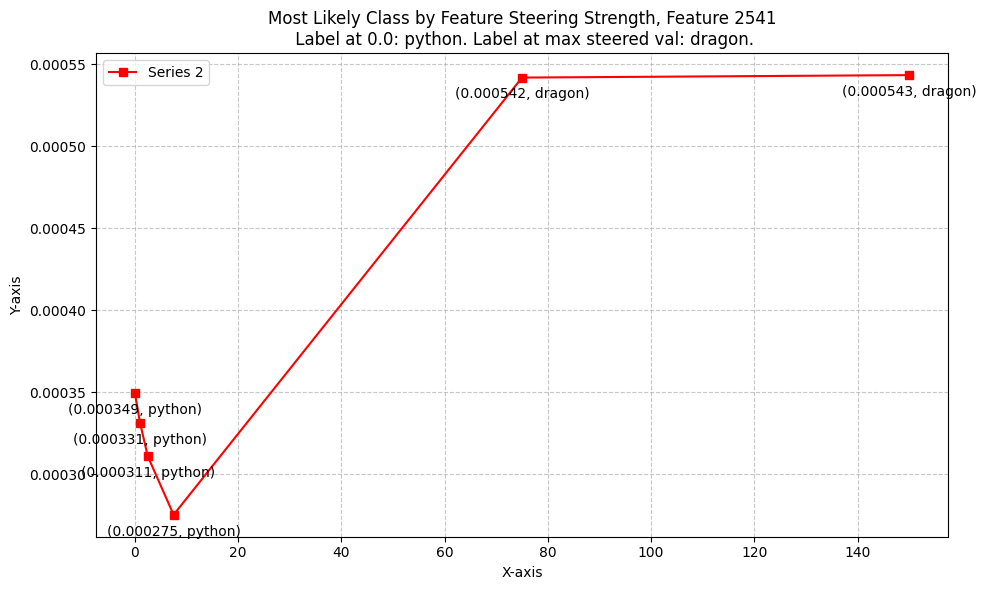

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
# y3 = [tup[1] for tup in sorted(feat_num_ratio_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
# plt.plot(x, y1, 'bo-', label='Series 1')  # Blue line with circles
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares
# plt.plot(x, y3, 'gd-', label='Series 3')  # Green line with diamonds

# Label each point for all three series
for i in range(len(x)):
#     # Labels for series 1
#     plt.annotate(f'({x[i]}, {y1[i]})', 
#                 (x[i], y1[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')
    
    # Labels for series 2
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
#     # Labels for series 3
#     plt.annotate(f'({x[i]}, {y3[i]})', 
#                 (x[i], y3[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_info[0.0][0][feat_num]}. Label at max steered val: {steering_strength_info[max(list(steering_strength_info.keys()))][0][feat_num]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

## Enc/Dec Clustering/Exploration

In [224]:
encoder_weights_for_math = sparse_autoencoder.W_enc
decoder_weights_for_math = sparse_autoencoder.W_dec

In [261]:
dists_from_feat_0 = encoder_weights_for_math[0] - encoder_weights_for_math

In [279]:
dists_from_feat_0_normalized = encoder_weights_for_math[0]/encoder_weights_for_math[0].norm(p=2) - encoder_weights_for_math/encoder_weights_for_math.norm(p=2,dim=0)

In [262]:
dists_from_feat_0.norm(p=2, dim=0).shape

torch.Size([49152])

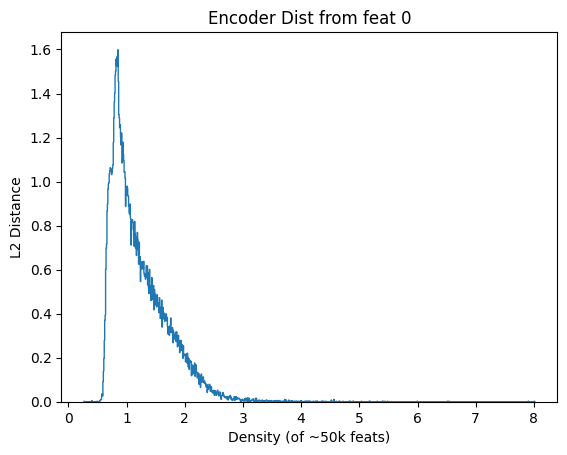

In [280]:
# plt.hist(bins[:-1], bins)
plt.hist(dists_from_feat_0.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Encoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [222]:
torch.topk(dists_from_feat_0.norm(p=2, dim=0),k=10,largest=False)

torch.return_types.topk(
values=tensor([0.2669, 0.3993, 0.4042, 0.4919, 0.5330, 0.5413, 0.5465, 0.5468, 0.5490,
        0.5538], device='cuda:0'),
indices=tensor([ 9777, 19829, 14140, 24701, 17384, 44489, 47300, 45112,  5297, 15368],
       device='cuda:0'))

In [281]:
dec_dists_from_feat_0 = decoder_weights_for_math[0]/decoder_weights_for_math[0].norm(p=2) - decoder_weights_for_math/decoder_weights_for_math.norm(p=2)
dec_dists_from_feat_0.shape

torch.Size([49152, 768])

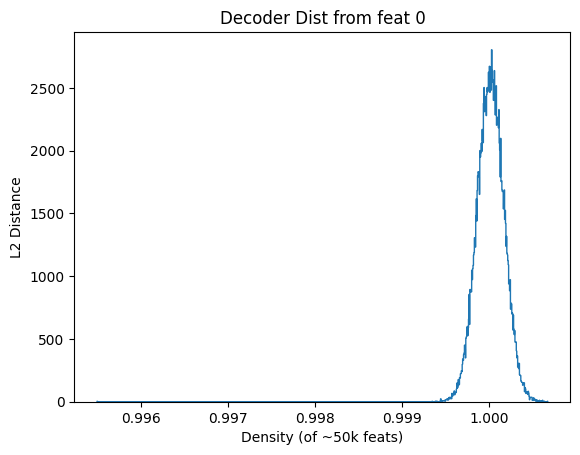

In [282]:
# plt.hist(bins[:-1], bins)
plt.hist(dec_dists_from_feat_0.T.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Decoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [248]:
torch.topk(dec_dists_from_feat_0.T.norm(p=2, dim=0),k=10,largest=False)

torch.return_types.topk(
values=tensor([0.0000, 1.3056, 1.3120, 1.3134, 1.3155, 1.3209, 1.3221, 1.3221, 1.3222,
        1.3227], device='cuda:0'),
indices=tensor([    0,  3256, 22171, 39781, 28196, 34233, 26573, 34134, 13175, 34499],
       device='cuda:0'))

In [247]:
dec_dists_from_feat_0.T.norm(p=2, dim=0).shape

torch.Size([49152])